## Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator!

### 撰寫一個 Generator，一次吐出 list 中的一個值

In [1]:
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [2]:
my_list = [1, 2, 3, 4, 5]

In [3]:
gen = output_from_list_generator(my_list)

In [4]:
print(next(gen))

1


In [5]:
print(next(gen))

2


In [6]:
print(next(gen))

3


In [7]:
print(next(gen))

4


In [8]:
print(next(gen))

5


In [9]:
print(next(gen))

StopIteration: 

### 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值

### 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可

In [10]:
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [11]:
gen = inf_loop_generator(my_list)

In [12]:
print(next(gen))

1


In [13]:
print(next(gen))

2


In [14]:
print(next(gen))

3


In [15]:
print(next(gen))

4


In [16]:
print(next(gen))

5


In [17]:
print(next(gen))

1


In [18]:
print(next(gen))

2


### 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

## 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [19]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [20]:
from keras.datasets import cifar10

In [21]:
(x_train, x_test), (y_train, y_test) = cifar10.load_data()

In [22]:
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = x_test[indexs: indexs+batch_size]
            yield images, labels

In [23]:
cifar_gen = cifar_generator(x_train)

In [24]:
images, labels = next(cifar_gen)

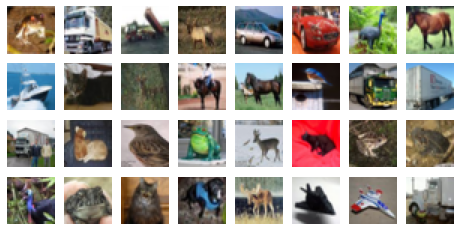

In [25]:
img_combine(images)

In [26]:
images, labels = next(cifar_gen)

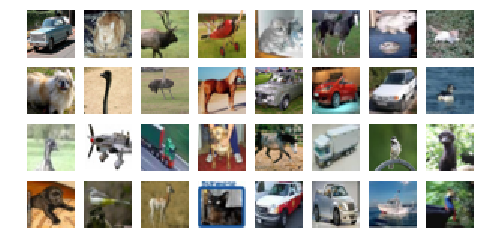

In [54]:
img_combine(images)

## 可以看到兩次的圖片並不一樣，這樣就可以開始訓練囉！

## 作業

請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [27]:
batch_size = 1000 #128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [28]:
len(x_train)

50000

In [37]:
import numpy as np
def data_generator(x, y, batch_size):
    idx = 0
    while True:
        if (idx+batch_size) <= x.shape[0]:
            idx_list = [i for i in range(idx, idx+batch_size)]
            print("\n idx_list:", idx_list[0], "~", idx_list[-1])
            idx = idx+batch_size
            
            yield np.array(x[idx_list]), np.array(y[idx_list])
        else:
            idx = 0
     

In [38]:
train_generator = data_generator(x_train, y_train, batch_size)
test_generator = data_generator(x_test, y_test, batch_size)

In [39]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_42 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_43 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 64)       

In [40]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(x_train)//batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_generator,
                    validation_steps=len(x_test)//batch_size
                   )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


 idx_list: 0 ~ 999
Epoch 1/10

 idx_list: 1000 ~ 1999
 1/50 [..............................] - ETA: 0s - loss: 66.6243 - accuracy: 0.0800
 idx_list: 2000 ~ 2999
 2/50 [>.............................] - ETA: 6s - loss: 86.3403 - accuracy: 0.0830
 idx_list: 3000 ~ 3999
 3/50 [>.............................] - ETA: 8s - loss: 63.6388 - accuracy: 0.0907
 idx_list: 4000 ~ 4999
 4/50 [=>............................] - ETA: 9s - loss: 48.7106 - accuracy: 0.0930
 idx_list: 5000 ~ 5999
 5/50 [==>...........................] - ETA: 9s - loss: 39.4836 - accuracy: 0.0960
 idx_list: 6000 ~ 6999
 6/50 [==>...........................] - ETA: 9s - loss: 33.3145 - accuracy: 0.1002
 idx_list: 7000 ~ 7999
 7/50 [===>..........................] - ETA: 9s - loss: 28.8992 - accuracy: 0.1017
 idx_list: 8000 ~ 8999
 8/50 [===>..........................] - ETA: 9s - loss: 25.5841 - accuracy: 0.1036
 idx_list: 9000 ~ 9999
 9/50 [====>.........................] - ETA: 9s - loss: 23.0131 - accuracy: 0.1038
 idx_

23/50 [============>.................] - ETA: 6s - loss: 2.3723 - accuracy: 0.1427
 idx_list: 24000 ~ 24999
24/50 [=============>................] - ETA: 6s - loss: 2.3692 - accuracy: 0.1412
 idx_list: 25000 ~ 25999
25/50 [==============>...............] - ETA: 6s - loss: 2.3660 - accuracy: 0.1399
 idx_list: 26000 ~ 26999
26/50 [==============>...............] - ETA: 6s - loss: 2.3629 - accuracy: 0.1396
 idx_list: 27000 ~ 27999
27/50 [===============>..............] - ETA: 5s - loss: 2.3605 - accuracy: 0.1387
 idx_list: 28000 ~ 28999
28/50 [===============>..............] - ETA: 5s - loss: 2.3574 - accuracy: 0.1385
 idx_list: 29000 ~ 29999
29/50 [================>.............] - ETA: 5s - loss: 2.3541 - accuracy: 0.1394
 idx_list: 30000 ~ 30999
30/50 [=================>............] - ETA: 5s - loss: 2.3510 - accuracy: 0.1393
 idx_list: 31000 ~ 31999
31/50 [=================>............] - ETA: 4s - loss: 2.3489 - accuracy: 0.1389
 idx_list: 32000 ~ 32999
32/50 [==================>..

45/50 [==========================>...] - ETA: 1s - loss: 2.3692 - accuracy: 0.1652
 idx_list: 46000 ~ 46999
46/50 [==========================>...] - ETA: 1s - loss: 2.3673 - accuracy: 0.1650
 idx_list: 47000 ~ 47999
47/50 [===========================>..] - ETA: 0s - loss: 2.3623 - accuracy: 0.1660
 idx_list: 48000 ~ 48999
48/50 [===========================>..] - ETA: 0s - loss: 2.3567 - accuracy: 0.1677
 idx_list: 49000 ~ 49999
49/50 [============================>.] - ETA: 0s - loss: 2.3512 - accuracy: 0.1689
 idx_list: 0 ~ 999
50/50 [==============================] - ETA: 0s - loss: 2.3499 - accuracy: 0.1698
 idx_list: 2000 ~ 2999

 idx_list: 3000 ~ 3999

 idx_list: 4000 ~ 4999

 idx_list: 5000 ~ 5999

 idx_list: 6000 ~ 6999

 idx_list: 7000 ~ 7999

 idx_list: 8000 ~ 8999

 idx_list: 9000 ~ 9999

 idx_list: 0 ~ 999

 idx_list: 1000 ~ 1999

 idx_list: 2000 ~ 2999
50/50 [==============================] - 14s 289ms/step - loss: 2.3499 - accuracy: 0.1698 - val_loss: 2.1416 - val_accuracy:

13/50 [======>.......................] - ETA: 9s - loss: 2.1454 - accuracy: 0.2712
 idx_list: 14000 ~ 14999
14/50 [=======>......................] - ETA: 9s - loss: 2.1294 - accuracy: 0.2751
 idx_list: 15000 ~ 15999
15/50 [========>.....................] - ETA: 8s - loss: 2.1145 - accuracy: 0.2777
 idx_list: 16000 ~ 16999
16/50 [========>.....................] - ETA: 8s - loss: 2.1042 - accuracy: 0.2790
 idx_list: 17000 ~ 17999
17/50 [=========>....................] - ETA: 8s - loss: 2.0927 - accuracy: 0.2803
 idx_list: 18000 ~ 18999
18/50 [=========>....................] - ETA: 8s - loss: 2.0758 - accuracy: 0.2848
 idx_list: 19000 ~ 19999
19/50 [==========>...................] - ETA: 8s - loss: 2.0636 - accuracy: 0.2882
 idx_list: 20000 ~ 20999
20/50 [===========>..................] - ETA: 7s - loss: 2.0519 - accuracy: 0.2921
 idx_list: 21000 ~ 21999
21/50 [===========>..................] - ETA: 7s - loss: 2.0412 - accuracy: 0.2953
 idx_list: 22000 ~ 22999
22/50 [============>........

35/50 [====================>.........] - ETA: 3s - loss: 1.7386 - accuracy: 0.3849
 idx_list: 36000 ~ 36999
36/50 [====================>.........] - ETA: 3s - loss: 1.7344 - accuracy: 0.3856
 idx_list: 37000 ~ 37999
37/50 [=====================>........] - ETA: 3s - loss: 1.7312 - accuracy: 0.3867
 idx_list: 38000 ~ 38999
38/50 [=====================>........] - ETA: 3s - loss: 1.7270 - accuracy: 0.3878
 idx_list: 39000 ~ 39999
39/50 [======================>.......] - ETA: 2s - loss: 1.7220 - accuracy: 0.3893
 idx_list: 40000 ~ 40999
40/50 [=======================>......] - ETA: 2s - loss: 1.7259 - accuracy: 0.3891
 idx_list: 41000 ~ 41999
41/50 [=======================>......] - ETA: 2s - loss: 1.7386 - accuracy: 0.3858
 idx_list: 42000 ~ 42999
42/50 [========================>.....] - ETA: 2s - loss: 1.7450 - accuracy: 0.3832
 idx_list: 43000 ~ 43999
43/50 [========================>.....] - ETA: 1s - loss: 1.7496 - accuracy: 0.3820
 idx_list: 44000 ~ 44999
44/50 [=====================

 3/50 [>.............................] - ETA: 8s - loss: 1.4786 - accuracy: 0.4920
 idx_list: 4000 ~ 4999
 4/50 [=>............................] - ETA: 9s - loss: 1.4842 - accuracy: 0.4877
 idx_list: 5000 ~ 5999
 5/50 [==>...........................] - ETA: 9s - loss: 1.4892 - accuracy: 0.4824
 idx_list: 6000 ~ 6999
 6/50 [==>...........................] - ETA: 10s - loss: 1.5106 - accuracy: 0.4742
 idx_list: 7000 ~ 7999
 7/50 [===>..........................] - ETA: 10s - loss: 1.5115 - accuracy: 0.4729
 idx_list: 8000 ~ 8999
 8/50 [===>..........................] - ETA: 10s - loss: 1.5155 - accuracy: 0.4706
 idx_list: 9000 ~ 9999
 9/50 [====>.........................] - ETA: 9s - loss: 1.5148 - accuracy: 0.4688 
 idx_list: 10000 ~ 10999
10/50 [=====>........................] - ETA: 9s - loss: 1.5086 - accuracy: 0.4686
 idx_list: 11000 ~ 11999
11/50 [=====>........................] - ETA: 9s - loss: 1.5080 - accuracy: 0.4692
 idx_list: 12000 ~ 12999
12/50 [======>......................

25/50 [==============>...............] - ETA: 6s - loss: 1.3817 - accuracy: 0.5222
 idx_list: 26000 ~ 26999
26/50 [==============>...............] - ETA: 6s - loss: 1.3771 - accuracy: 0.5238
 idx_list: 27000 ~ 27999
27/50 [===============>..............] - ETA: 6s - loss: 1.3737 - accuracy: 0.5246
 idx_list: 28000 ~ 28999
28/50 [===============>..............] - ETA: 5s - loss: 1.3708 - accuracy: 0.5254
 idx_list: 29000 ~ 29999
29/50 [================>.............] - ETA: 5s - loss: 1.3664 - accuracy: 0.5266
 idx_list: 30000 ~ 30999
30/50 [=================>............] - ETA: 5s - loss: 1.3632 - accuracy: 0.5278
 idx_list: 31000 ~ 31999
31/50 [=================>............] - ETA: 5s - loss: 1.3608 - accuracy: 0.5285
 idx_list: 32000 ~ 32999
32/50 [==================>...........] - ETA: 4s - loss: 1.3586 - accuracy: 0.5296
 idx_list: 33000 ~ 33999
33/50 [==================>...........] - ETA: 4s - loss: 1.3620 - accuracy: 0.5287
 idx_list: 34000 ~ 34999
34/50 [===================>.

47/50 [===========================>..] - ETA: 0s - loss: 1.2991 - accuracy: 0.5494
 idx_list: 48000 ~ 48999
48/50 [===========================>..] - ETA: 0s - loss: 1.3094 - accuracy: 0.5468
 idx_list: 49000 ~ 49999
49/50 [============================>.] - ETA: 0s - loss: 1.3195 - accuracy: 0.5440
 idx_list: 0 ~ 999
50/50 [==============================] - ETA: 0s - loss: 1.3360 - accuracy: 0.5386
 idx_list: 9000 ~ 9999

 idx_list: 0 ~ 999

 idx_list: 1000 ~ 1999

 idx_list: 2000 ~ 2999

 idx_list: 3000 ~ 3999

 idx_list: 4000 ~ 4999

 idx_list: 5000 ~ 5999

 idx_list: 6000 ~ 6999

 idx_list: 7000 ~ 7999

 idx_list: 8000 ~ 8999

 idx_list: 9000 ~ 9999
50/50 [==============================] - 14s 288ms/step - loss: 1.3360 - accuracy: 0.5386 - val_loss: 1.6286 - val_accuracy: 0.4310
Test loss: 1.6286046504974365
Test accuracy: 0.4309999942779541
